#**🔶 Predictive Maintenance for Equipment Failure Detection Notebook**

**💭 Project Overview:**

Our project focuses on applying data science techniques to forecast equipment malfunctions,

minimize downtime, and optimize maintenance scheduling.

##**▶️ Downloading Dependencies**

In [1]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.9 MB/s eta 0:00:00


##**▶️ Importing Libraries**

In [21]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
from catboost import CatBoostClassifier, Pool
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import learning_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

##**1. Loading the cleaned dataset**

In [35]:
file_path = "cleaned_dataset_for_modeling.csv"
df = pd.read_csv(file_path)

##**2. Model Implementation**

We will apply these models:

- Long Short-Term Memory (LSTM)
- Random Forest
- Categorical boost (Catboost)

###**2.1. LSTM**

In [12]:
df.head(5)

,date,failure,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric8,metric9,year,month,day,weekday,sector_encoded,equipment_encoded
0,2015-01-01,0,0.883224,0.0,0.0,0.0,0.2500,0.898527,0.0,0.0,0.0,2015,1,1,3,0.0,0.029966
1,2015-01-01,0,0.251374,0.0,0.0,0.0,0.2500,0.886524,0.0,0.0,0.0,2015,1,1,3,0.0,0.037671
2,2015-01-01,0,0.709821,0.0,0.0,0.0,0.6250,0.419875,0.0,0.0,0.0,2015,1,1,3,0.0,0.052226
3,2015-01-01,0,0.326427,0.0,0.0,0.0,0.2500,0.906262,0.0,0.0,0.0,2015,1,1,3,0.0,0.056507
4,2015-01-01,0,0.556935,0.0,0.0,0.0,0.8125,0.633183,0.0,0.0,0.0,2015,1,1,3,0.0,0.063356


In [13]:
# Convert date to datetime
df['date'] = pd.to_datetime(df['date'])

# Sort by date for temporal consistency
df.sort_values(by='date', inplace=True)

# Normalize feature columns (exclude 'date' and 'failure')
feature_cols = [col for col in df.columns if col not in ['date', 'failure']]
scaler = MinMaxScaler()
df[feature_cols] = scaler.fit_transform(df[feature_cols])

In [14]:
df.head(5)

,date,failure,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric8,metric9,year,month,day,weekday,sector_encoded,equipment_encoded
0,2015-01-01,0,0.883224,0.0,0.0,0.0,0.2500,0.898527,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.000000,0.029966
779,2015-01-01,0,0.959770,0.0,0.0,0.0,0.1250,0.274565,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.333333,0.971747
778,2015-01-01,0,0.367250,0.0,0.0,0.0,0.3125,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.333333,0.970034
777,2015-01-01,0,0.663608,0.0,0.0,0.0,0.6250,0.364399,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.333333,0.969178
776,2015-01-01,0,0.053815,0.0,0.0,0.0,0.4375,0.290247,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.333333,0.968322


In [15]:
# Prepare sequences
sequence_length = 10
features = df[feature_cols].values
labels = df['failure'].values

X_seq, y_seq = [], []
for i in range(sequence_length, len(df)):
    X_seq.append(features[i-sequence_length:i])
    y_seq.append(labels[i])

X_seq = np.array(X_seq)
y_seq = np.array(y_seq)

In [16]:
# Reshape for SMOTE (2D)
X_seq_2d = X_seq.reshape((X_seq.shape[0], -1))

# Apply SMOTE
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_seq_2d, y_seq)

# Reshape back to 3D for LSTM
X_res = X_res.reshape((X_res.shape[0], sequence_length, len(feature_cols)))
y_res_cat = to_categorical(y_res, num_classes=2)

In [17]:
# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X_res, y_res_cat, test_size=0.2, random_state=42, stratify=y_res)

In [18]:
# Build LSTM model
model = Sequential([
    LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(2, activation='softmax')
])

# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
3110/3110 ━━━━━━━━━━━━━━━━━━━━ 41s 12ms/step - accuracy: 0.7167 - loss: 0.5106 - val_accuracy: 0.9471 - val_loss: 0.1460
Epoch 2/30
3110/3110 ━━━━━━━━━━━━━━━━━━━━ 37s 12ms/step - accuracy: 0.9497 - loss: 0.1441 - val_accuracy: 0.9841 - val_loss: 0.0550
Epoch 3/30
3110/3110 ━━━━━━━━━━━━━━━━━━━━ 38s 12ms/step - accuracy: 0.9755 - loss: 0.0783 - val_accuracy: 0.9871 - val_loss: 0.0430
Epoch 4/30
3110/3110 ━━━━━━━━━━━━━━━━━━━━ 40s 12ms/step - accuracy: 0.9854 - loss: 0.0498 - val_accuracy: 0.9929 - val_loss: 0.0257
Epoch 5/30
3110/3110 ━━━━━━━━━━━━━━━━━━━━ 37s 12ms/step - accuracy: 0.9890 - loss: 0.0375 - val_accuracy: 0.9930 - val_loss: 0.0241
Epoch 6/30
3110/3110 ━━━━━━━━━━━━━━━━━━━━ 41s 12ms/step - accuracy: 0.9918 - loss: 0.0289 - val_accuracy: 0.9941 - val_loss: 0.0220
Epoch 7/30
3110/3110 ━━━━━━━━━━━━━━━━━━━━ 38s 12ms/step - accuracy: 0.9935 - loss: 0.0226 - val_accuracy: 0.9911 - val_loss: 0.0317
Epoch 8/30
3110/3110 ━━━━━━━━━━━━━━━━━━━━ 39s 12ms/step - accuracy: 0.9940 -

In [20]:
y_pred_classes = np.argmax(model.predict(X_val), axis=1)
y_true_classes = np.argmax(y_val, axis=1)

print("Accuracy:", accuracy_score(y_true_classes, y_pred_classes))
print("Precision:", precision_score(y_true_classes, y_pred_classes, average='macro'))
print("Recall:", recall_score(y_true_classes, y_pred_classes, average='macro'))
print("F1 Score:", f1_score(y_true_classes, y_pred_classes, average='macro'))

1555/1555 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step
Accuracy: 0.9987337192474675
Precision: 0.9987369180801156
Recall: 0.9987337192474675
F1 Score: 0.9987337172170249


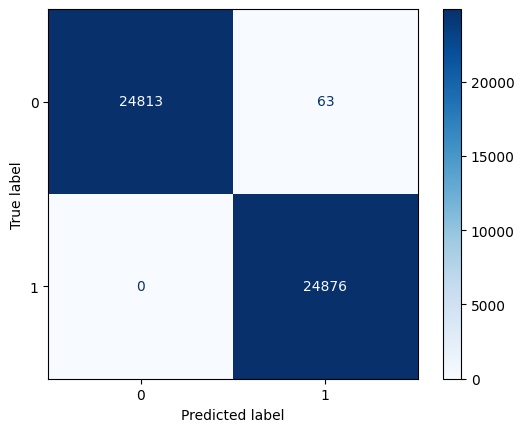

In [22]:
cm = confusion_matrix(y_true_classes, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.show()

In [23]:
# Model Summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        20,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 67,880 (265.16 KB)

 Trainable params: 22,626 (88.38 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 45,254 (176.78 KB)

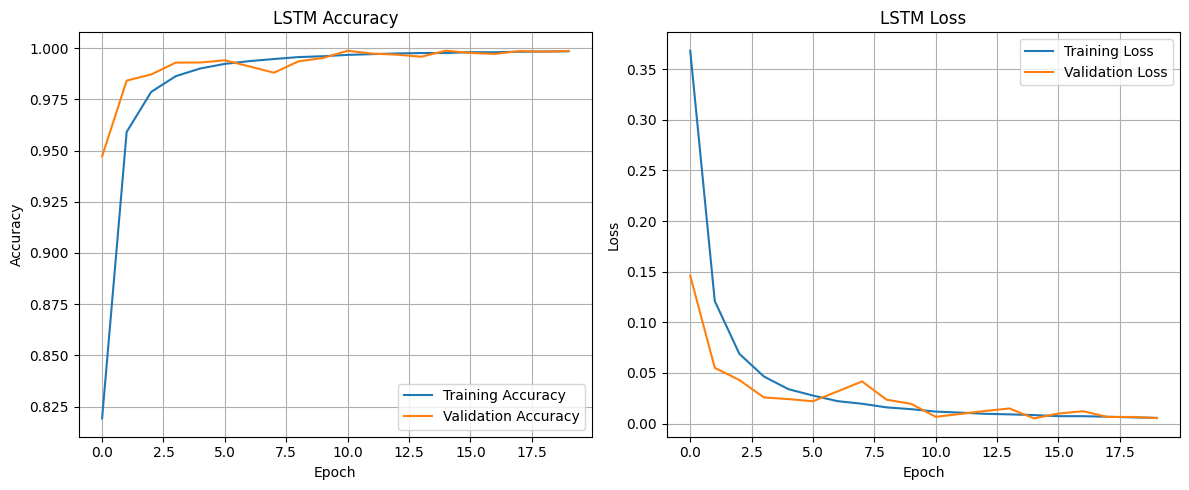

In [24]:
# Plot Accuracy and Loss
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('LSTM Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

###**2.2. Random Forest**

In [26]:
# Convert 'date' column to datetime and sort
df['date'] = pd.to_datetime(df['date'])
df.sort_values(by='date', inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 124494 entries, 0 to 124493
Data columns (total 17 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   date               124494 non-null  datetime64[ns]
 1   failure            124494 non-null  int64         
 2   metric1            124494 non-null  float64       
 3   metric2            124494 non-null  float64       
 4   metric3            124494 non-null  float64       
 5   metric4            124494 non-null  float64       
 6   metric5            124494 non-null  float64       
 7   metric6            124494 non-null  float64       
 8   metric7            124494 non-null  float64       
 9   metric8            124494 non-null  float64       
 10  metric9            124494 non-null  float64       
 11  year               124494 non-null  int64         
 12  month              124494 non-null  int64         
 13  day                124494 non-null  int64        

In [27]:
df.head(5)

,date,failure,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric8,metric9,year,month,day,weekday,sector_encoded,equipment_encoded
0,2015-01-01,0,0.883224,0.0,0.0,0.0,0.2500,0.898527,0.0,0.0,0.0,2015,1,1,3,0.000000,0.029966
779,2015-01-01,0,0.959770,0.0,0.0,0.0,0.1250,0.274565,0.0,0.0,0.0,2015,1,1,3,0.333333,0.971747
778,2015-01-01,0,0.367250,0.0,0.0,0.0,0.3125,0.000000,0.0,0.0,0.0,2015,1,1,3,0.333333,0.970034
777,2015-01-01,0,0.663608,0.0,0.0,0.0,0.6250,0.364399,0.0,0.0,0.0,2015,1,1,3,0.333333,0.969178
776,2015-01-01,0,0.053815,0.0,0.0,0.0,0.4375,0.290247,0.0,0.0,0.0,2015,1,1,3,0.333333,0.968322


In [28]:
# Define features and labels
feature_cols = [col for col in df.columns if col not in ['date', 'failure']]
X = df[feature_cols]
y = df['failure']

# Normalize features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [29]:
# Apply SMOTE to balance classes
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_scaled, y)

In [30]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42, stratify=y_res)

# Train Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, max_depth=20, class_weight='balanced', random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=20, random_state=42)

In [31]:
y_pred = rf_model.predict(X_test)

# Accuracy and other metrics
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print(f"Precision: {precision_score(y_test, y_pred, average='macro'):.2f}")
print(f"Recall: {recall_score(y_test, y_pred, average='macro'):.2f}")
print(f"F1 Score: {f1_score(y_test, y_pred, average='macro'):.2f}")

Accuracy: 1.00
Precision: 1.00
Recall: 1.00
F1 Score: 1.00


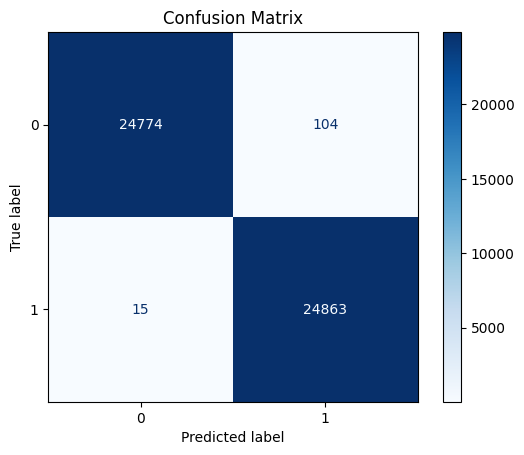

In [32]:
y_pred = rf_model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

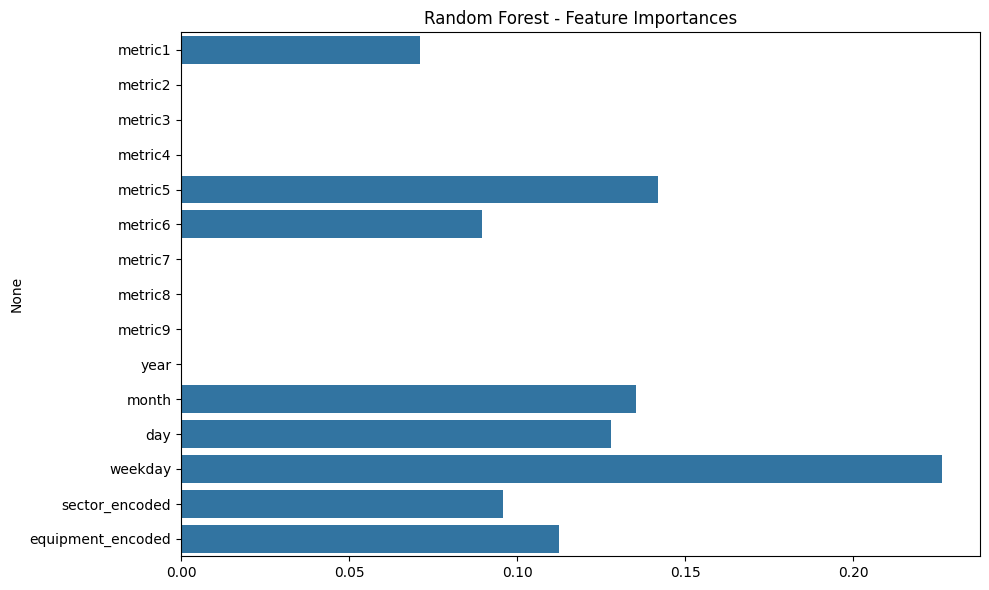

In [33]:
# Feature Importance
feature_importances = pd.Series(rf_model.feature_importances_, index=feature_cols)
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances.values, y=feature_importances.index)
plt.title("Random Forest - Feature Importances")
plt.tight_layout()
plt.show()

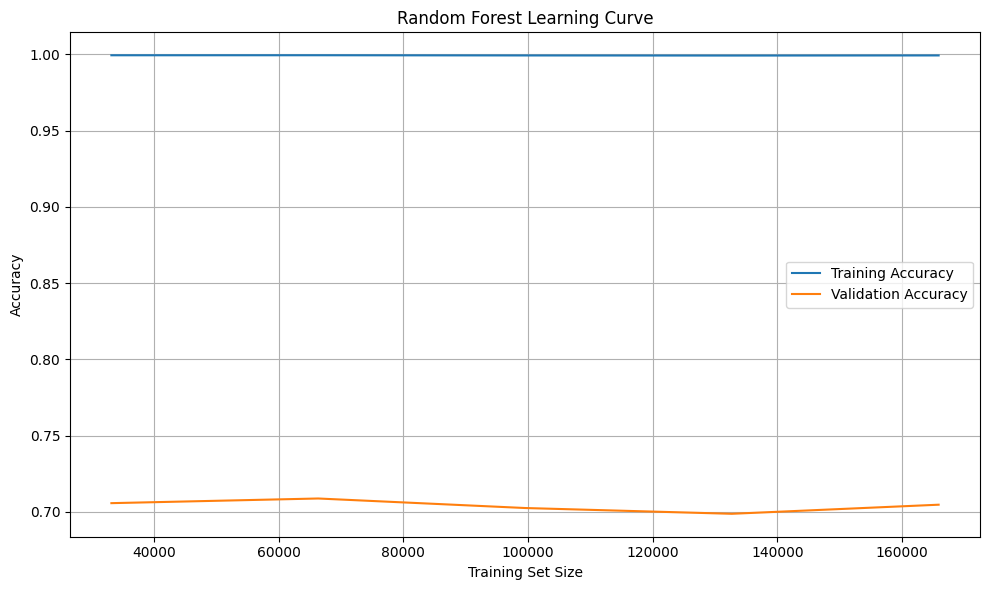

In [34]:
# Learning Curve
train_sizes, train_scores, val_scores = learning_curve(
    rf_model, X_res, y_res,
    cv=3,
    scoring='accuracy',
    train_sizes=np.linspace(0.2, 1.0, 5),
    n_jobs=-1,
    shuffle=True,
    random_state=42
)

train_scores_mean = train_scores.mean(axis=1)
val_scores_mean = val_scores.mean(axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Training Accuracy')
plt.plot(train_sizes, val_scores_mean, label='Validation Accuracy')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.title('Random Forest Learning Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

###**2.3. Catboost**

In [36]:
# Convert and sort by date
df['date'] = pd.to_datetime(df['date'])
df.sort_values(by='date', inplace=True)

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 124494 entries, 0 to 124493
Data columns (total 17 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   date               124494 non-null  datetime64[ns]
 1   failure            124494 non-null  int64         
 2   metric1            124494 non-null  float64       
 3   metric2            124494 non-null  float64       
 4   metric3            124494 non-null  float64       
 5   metric4            124494 non-null  float64       
 6   metric5            124494 non-null  float64       
 7   metric6            124494 non-null  float64       
 8   metric7            124494 non-null  float64       
 9   metric8            124494 non-null  float64       
 10  metric9            124494 non-null  float64       
 11  year               124494 non-null  int64         
 12  month              124494 non-null  int64         
 13  day                124494 non-null  int64        

In [38]:
# Define features and target
feature_cols = [col for col in df.columns if col not in ['date', 'failure']]
X = df[feature_cols]
y = df['failure']

# Normalize features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [39]:
# Apply SMOTE
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_scaled, y)

In [40]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, stratify=y_res, random_state=42)

# Initialize and train CatBoost model
cat_model = CatBoostClassifier(
    iterations=500,
    depth=6,
    learning_rate=0.1,
    loss_function='Logloss',
    eval_metric='Accuracy',
    verbose=50,
    random_seed=42
)

cat_model.fit(X_train, y_train, eval_set=(X_test, y_test), use_best_model=True)

0:	learn: 0.7116973	test: 0.7087989	best: 0.7087989 (0)	total: 148ms	remaining: 1m 13s
50:	learn: 0.9962717	test: 0.9962417	best: 0.9962417 (50)	total: 4.62s	remaining: 40.7s
100:	learn: 0.9991508	test: 0.9991157	best: 0.9991961 (90)	total: 7.29s	remaining: 28.8s
150:	learn: 0.9993920	test: 0.9994574	best: 0.9994774 (149)	total: 9.97s	remaining: 23.1s
200:	learn: 0.9994925	test: 0.9994574	best: 0.9994774 (149)	total: 12.6s	remaining: 18.8s
250:	learn: 0.9995327	test: 0.9994774	best: 0.9994774 (149)	total: 17.1s	remaining: 17s
300:	learn: 0.9995428	test: 0.9994774	best: 0.9994774 (149)	total: 19.5s	remaining: 12.9s
350:	learn: 0.9995679	test: 0.9994975	best: 0.9994975 (301)	total: 21.9s	remaining: 9.31s
400:	learn: 0.9995679	test: 0.9994975	best: 0.9994975 (301)	total: 24.2s	remaining: 5.97s
450:	learn: 0.9995729	test: 0.9994975	best: 0.9994975 (301)	total: 26.4s	remaining: 2.87s
499:	learn: 0.9995880	test: 0.9994975	best: 0.9994975 (301)	total: 30.5s	remaining: 0us

bestTest = 0.999497

In [41]:
y_pred = cat_model.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print(f"Precision: {precision_score(y_test, y_pred, average='macro'):.2f}")
print(f"Recall: {recall_score(y_test, y_pred, average='macro'):.2f}")
print(f"F1 Score: {f1_score(y_test, y_pred, average='macro'):.2f}")

Accuracy: 1.00
Precision: 1.00
Recall: 1.00
F1 Score: 1.00


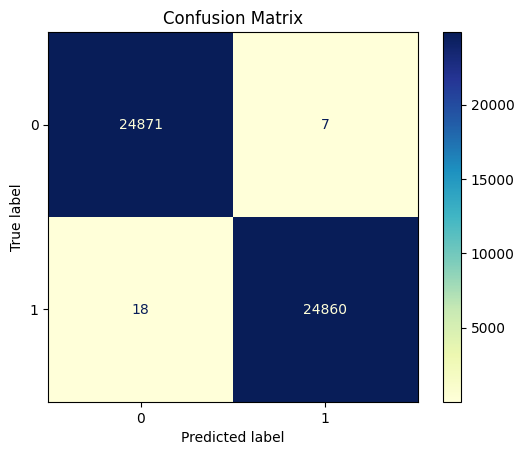

In [42]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="YlGnBu")
plt.title("Confusion Matrix")
plt.show()

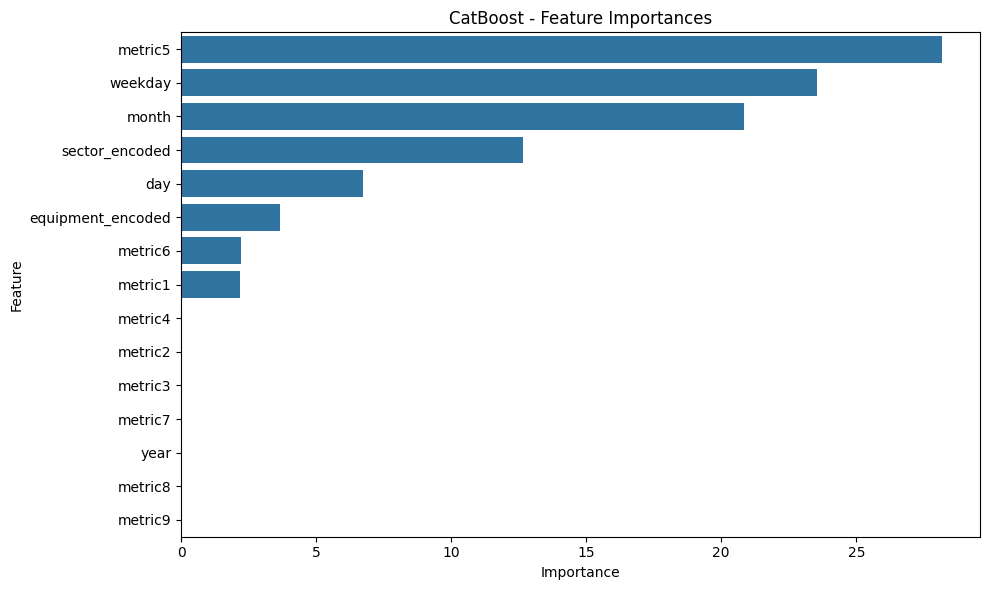

In [43]:
# Get feature importances
importances = cat_model.get_feature_importance()
feature_names = X.columns  # Make sure X refers to the features used in training

# Create a DataFrame for plotting
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot using seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title("CatBoost - Feature Importances")
plt.tight_layout()
plt.show()

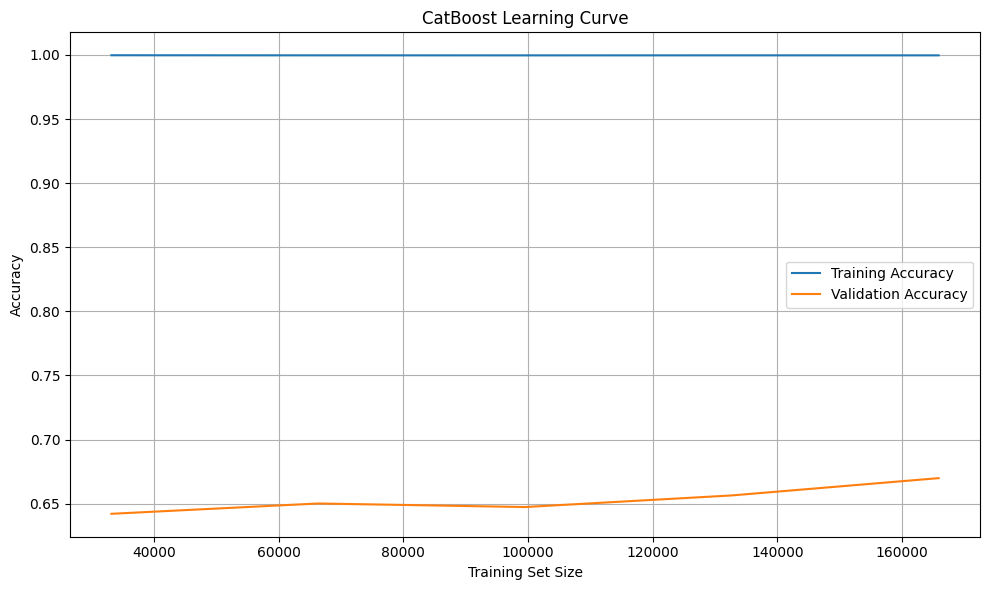

In [44]:
# Learning Curve
train_sizes, train_scores, val_scores = learning_curve(
    cat_model, X_res, y_res,
    cv=3,
    scoring='accuracy',
    train_sizes=np.linspace(0.2, 1.0, 5),
    n_jobs=-1,
    shuffle=True,
    random_state=42
)

train_scores_mean = train_scores.mean(axis=1)
val_scores_mean = val_scores.mean(axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Training Accuracy')
plt.plot(train_sizes, val_scores_mean, label='Validation Accuracy')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.title('CatBoost Learning Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#**✅ END**